In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import mysql.connector
import pickle

%matplotlib inline

In [ ]:
#Demographics like age, gender, and account details of our clients
client_profile_df = pd.read_csv('df_final_demo.txt')

#A detailed trace of client interactions online
digital_footprints_1 = pd.read_csv('df_final_web_data_pt_1.txt')
digital_footprints_2 = pd.read_csv('df_final_web_data_pt_2.txt')

#A list revealing which clients were part of the grand experiment
experiment_roster = pd.read_csv('df_final_experiment_clients.txt')

In [ ]:
client_profile_df

In [ ]:
client_profile_df.rename(columns = {'clnt_age':'age','gendr':'gender','bal':'balance','clnt_tenure_yr':'tenure_year','clnt_tenure_mnth':'tenure_month'},inplace=True)

In [ ]:
client_profile_df.drop('tenure_month', axis=1, inplace=True)

In [ ]:
client_profile_df['logons_6_mnth'].value_counts()

In [ ]:
client_profile_df.describe().round()

In [ ]:
client_profile_df['gender'].value_counts()

In [ ]:
client_profile_df['gender'] = client_profile_df['gender'].replace('X', 'U')

In [ ]:
client_profile_df['gender'].value_counts()

In [ ]:
bins = [0, 25, 50, 75, 100]  # Adjust the bin edges as needed
labels = ['Adolescent', 'Adult', 'Middle Age', 'Senior']

client_profile_df['name_age'] = pd.cut(client_profile_df['age'], bins=bins, labels=labels, right=False)

group_age = client_profile_df['name_age'].value_counts()

group_age.values

In [ ]:
client_profile_df['name_age'].isnull().sum()

In [ ]:
client_profile_df

In [ ]:
sns.barplot(x=group_age.index, y=group_age.values, palette="Set3");

### Conclusion:

The majority of clients are between the ages of 30 and 50 with an average of 46 years

Although many clients have an unknown gender, we can assume that they are divided fairly equal between male and female

The average years in Vanguard is 12 years

The average number of accounts per clients is 2 

In [ ]:
bins = [0, 3, 6, 9]  # Adjust the bin edges as needed
labels = ['Low', 'Average', 'Frequent']

client_profile_df['logins'] = pd.cut(client_profile_df['logons_6_mnth'], bins=bins, labels=labels, right=False)

primary = client_profile_df['logins'].value_counts()

primary.values

In [ ]:
sns.barplot(x=primary.index, y=primary.values, palette="Set3");

In [ ]:
filter= client_profile_df[client_profile_df['logons_6_mnth'] > 3]

primary_clients = filter[['age','gender','tenure_year','logons_6_mnth']]

primary_clients.describe()

In [ ]:
primary_clients.shape

In [ ]:
#The primary clients are older (middle aged) and long standing (average of 12 years)

### KPIs

> Completion Rate: The proportion of users who reach the final ‘confirm’ step.

> Time Spent on Each Step: The average duration users spend on each step.

> Error Rates: If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

    - Count of steps per visit_id

> Number of times a customer tried to complete the steps (number of visit_id per customer)

> At which step did the customers 'give up' (Abandonment Rate)

> The percentage of users who abandon the process at each step (Drop-off Rate)

In [2]:
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
# Connect to MySQL database
conn = mysql.connector.connect(host='127.0.0.1', user='root', passwd=password)
cursor = conn.cursor()

#Select the database
cursor.execute("USE vanguard")

In [5]:
cursor.execute("""
                    SELECT clients.client_id,
                        clients.clnt_age, 
                        clients.gendr, 
                        COUNT(distinct(interactions.process_step)) AS count_of_steps,
                        group_id.variation
                    FROM clients
                    JOIN interactions
                    ON clients.client_id = interactions.client_id
                    INNER JOIN group_id
                    ON group_id.client_id = clients.client_id
                    GROUP BY clients.client_id, clients.clnt_age, clients.gendr,group_id.variation;

                    """)
results = cursor.fetchall()

how_far = pd.DataFrame(results)

In [9]:
how_far

,0,1,2,3,4
0,1000062,52.5,F,5,Control
1,1000353,59.0,U,5,Control
2,1000536,27.0,U,5,Control
3,1000672,65.5,F,5,Control
4,1001101,61.5,M,5,Test
...,...,...,...,...,...
50495,9999150,30.0,U,2,Test
50496,9999400,28.5,U,5,Test
50497,9999626,35.0,M,2,Test
50498,9999729,31.0,F,5,Test


In [12]:
#rename columns to be descriptive

how_far.rename(columns = {0:'client_id',1:'age',2:'gender',3:'steps_reached',4:'group_status'},inplace=True)
how_far

,client_id,age,gender,steps_reached,group_status
0,1000062,52.5,F,5,Control
1,1000353,59.0,U,5,Control
2,1000536,27.0,U,5,Control
3,1000672,65.5,F,5,Control
4,1001101,61.5,M,5,Test
...,...,...,...,...,...
50495,9999150,30.0,U,2,Test
50496,9999400,28.5,U,5,Test
50497,9999626,35.0,M,2,Test
50498,9999729,31.0,F,5,Test


In [14]:
# Frequency table 
frequency_table = how_far['steps_reached'].value_counts()

# Calculating the proportion of people that reached and stopped at each step
proportion_table = how_far['steps_reached'].value_counts(normalize=True)

proportion_table, frequency_table

(steps_reached
 5    0.664238
 1    0.118436
 4    0.093129
 2    0.069347
 3    0.054851
 Name: proportion, dtype: float64,
 steps_reached
 5    33544
 1     5981
 4     4703
 2     3502
 3     2770
 Name: count, dtype: int64)

In [17]:
# Creating a crosstab table for the step_reached column, counting occurrences for each unique value
my_table = pd.crosstab(index = how_far["steps_reached"],  # Make a crosstab
                              columns="count")      # Name the count column
my_table

col_0,count
steps_reached,
1,5981
2,3502
3,2770
4,4703
5,33544


In [26]:
# Generating a crosstab for steps reached and group_status
crosstab_status = pd.crosstab(how_far['steps_reached'], how_far['group_status'])

crosstab_status

proportion_status = how_far[['steps_reached','group_status']].value_counts(normalize=True)
proportion_status

steps_reached  group_status
5              Test            0.363129
               Control         0.301109
1              Control         0.065881
               Test            0.052554
4              Test            0.049762
               Control         0.043366
2              Test            0.039861
               Control         0.029485
3              Test            0.028713
               Control         0.026139
Name: proportion, dtype: float64

In [22]:
from scipy.stats import chi2_contingency

# Chi-square test for steps reached and group_status
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_status)

chi2_statistic, chi2_p_value

#chi2_statistic = statistically significant
#chi2_p_value = indicates a statistically significant association between the groups and their progress in the process.

(242.18968189355118, 3.132391979694025e-51)

<Axes: xlabel='steps_reached'>

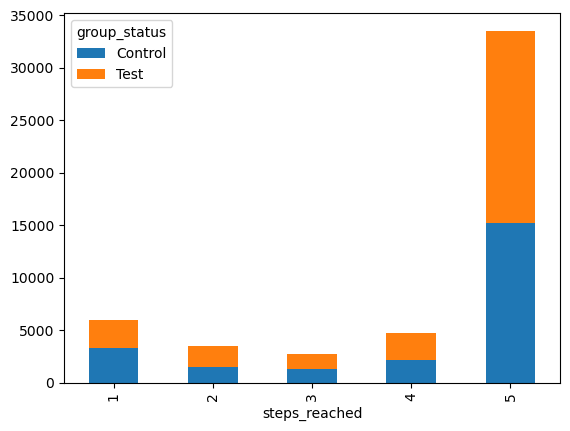

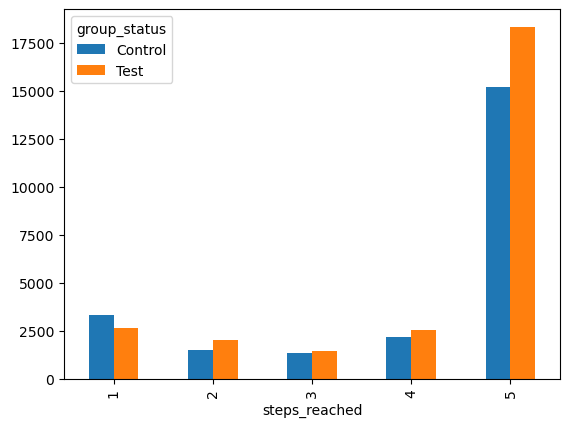

In [33]:
#stacked bar with test groups
crosstab_status.plot(kind="bar", stacked=True)

#bar with test groups
crosstab_status.plot(kind="bar", stacked=False)

<Axes: xlabel='steps_reached,group_status'>

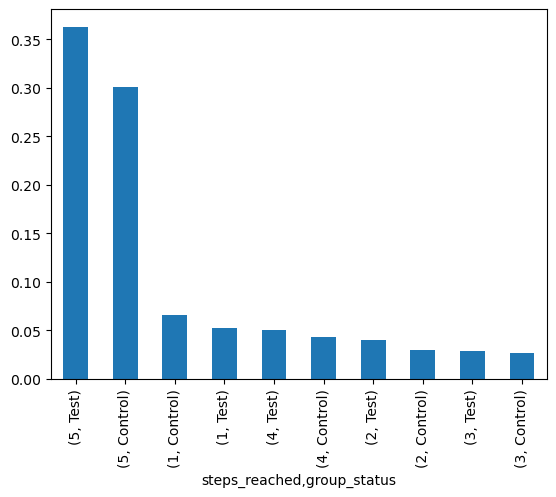

In [44]:
#bar with test groups proportions
proportion_status.plot(kind="bar")


C:\Users\NessaJay\AppData\Local\Temp\ipykernel_28648\3628697404.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequency_table.index, y=frequency_table.values, palette="Set3");


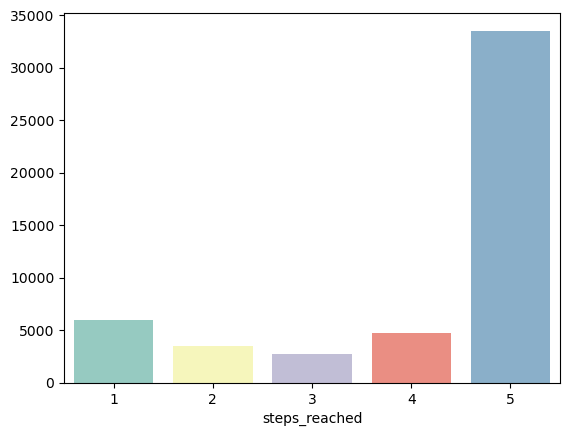

In [18]:
# graph regardless of test group
sns.barplot(x=frequency_table.index, y=frequency_table.values, palette="Set3");

##### Abandonment rate

Abandonment rate refers to the percentage of tasks users start but don't complete—such as leaving a survey midway, or adding an item to an online shopping cart but not purchasing. It’s a popular metric in the ecommerce industry, specifically for calculating cart abandonment rate.

How to calculate abandonment rate
Abandonment rate = (Number of intended tasks completed) / (Number of intended tasks initiated) x 100

How to calculate cart abandonment rate for ecommerce stores

Cart abandonment rate = (Number of carts abandoned / Number of orders initiated) x 100